In [ ]:
"""
MOFA Practical: Integrating RNA-seq, Proteomics, and Metabolomics Data
Author: Bioinformatics Tutorial
Description: Practical example of multi-omics integration using MOFA2 in Python
"""

# ============================================================================
# 1. INSTALLATION AND SETUP
# ============================================================================

# Install required packages (run once in terminal):
# pip install mofapy2
# pip install numpy pandas matplotlib seaborn scikit-learn

In [2]:
!pip install mofapy2

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 8.6 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 8.4 MB/s eta 0:00:008.6 MB/s eta 0:00:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13/13 [mofapy2];237m━━━ 12/13 [mofapy2]earn]


In [3]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mofapy2.run.entry_point import entry_point
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 2. SIMULATE MULTI-OMICS DATA

In [6]:
# In practice, you would load your own data. This simulation creates realistic
# multi-omics data with shared and unique patterns.

n_samples = 60  # Number of samples (e.g., patients or cell lines)

# Sample metadata
sample_metadata = pd.DataFrame({
    'sample': [f'Sample_{i}' for i in range(1, n_samples + 1)],
    'condition': ['Control'] * (n_samples // 2) + ['Disease'] * (n_samples // 2),
    'batch': ['Batch1', 'Batch2', 'Batch3'] * (n_samples // 3)
})

print("Sample Metadata")
print(sample_metadata.head())
print(sample_metadata.tail())

Sample Metadata
     sample condition   batch
0  Sample_1   Control  Batch1
1  Sample_2   Control  Batch2
2  Sample_3   Control  Batch3
3  Sample_4   Control  Batch1
4  Sample_5   Control  Batch2
       sample condition   batch
55  Sample_56   Disease  Batch2
56  Sample_57   Disease  Batch3
57  Sample_58   Disease  Batch1
58  Sample_59   Disease  Batch2
59  Sample_60   Disease  Batch3


### Simulate RNA-seq data

In [10]:
# Simulate RNA-seq data (e.g., 2000 genes)
n_genes = 2000
rnaseq_data = pd.DataFrame(
    np.random.normal(5, 2, (n_genes, n_samples)),
    index=[f'Gene_{i}' for i in range(1, n_genes + 1)],
    columns=sample_metadata['sample']
)

# Add signal: genes 1-200 correlated with disease
disease_effect = np.array([2 if c == 'Disease' else 0 for c in sample_metadata['condition']])
rnaseq_data.iloc[0:200, :] = (
    rnaseq_data.iloc[0:200, :] + 
    disease_effect + 
    np.random.normal(0, 0.5, (200, n_samples))
)

In [22]:
rnaseq_data.to_numpy().flatten()

array([5.88410317, 4.91494069, 6.66294806, ..., 1.40980621, 3.79753688,
       5.47036767], shape=(120000,))

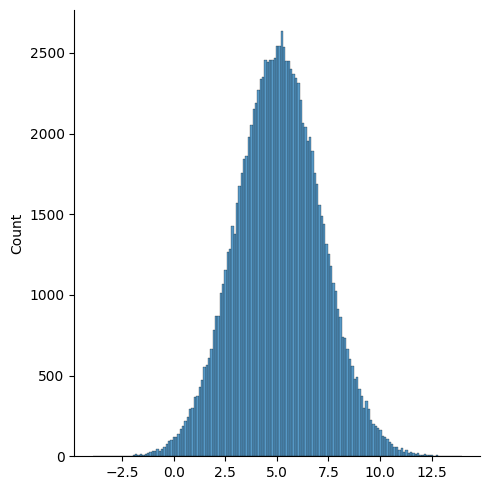

In [23]:
sns.displot(rnaseq_data.to_numpy().flatten())

### Simulate Proteomics data

In [11]:
# Simulate Proteomics data (e.g., 500 proteins)
n_proteins = 500
protein_data = pd.DataFrame(
    np.random.normal(10, 3, (n_proteins, n_samples)),
    index=[f'Protein_{i}' for i in range(1, n_proteins + 1)],
    columns=sample_metadata['sample']
)

# Add signal: proteins 1-100 correlated with disease (shared with RNA)
protein_data.iloc[0:100, :] = (
    protein_data.iloc[0:100, :] + 
    disease_effect + 
    np.random.normal(0, 0.5, (100, n_samples))
)

# Add signal: proteins 101-150 unique pattern (batch effect)
batch_effect = pd.Categorical(sample_metadata['batch']).codes
protein_data.iloc[100:150, :] = protein_data.iloc[100:150, :] + batch_effect

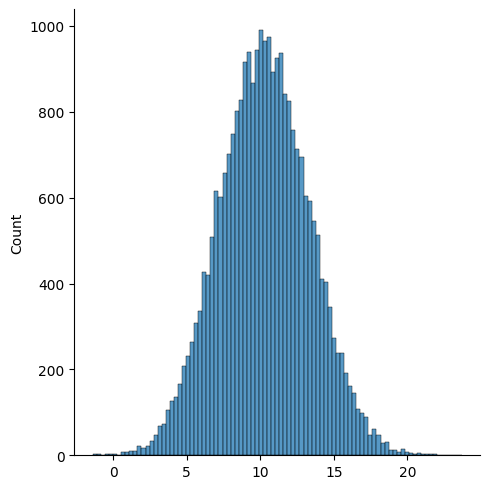

In [25]:
sns.displot(protein_data.to_numpy().flatten())

### Simulate Metabolomics data

In [12]:
# Simulate Metabolomics data (e.g., 150 metabolites)
n_metabolites = 150
metabolite_data = pd.DataFrame(
    np.random.normal(3, 1.5, (n_metabolites, n_samples)),
    index=[f'Metabolite_{i}' for i in range(1, n_metabolites + 1)],
    columns=sample_metadata['sample']
)

# Add signal: metabolites 1-30 correlated with disease
metabolite_data.iloc[0:30, :] = (
    metabolite_data.iloc[0:30, :] + 
    disease_effect + 
    np.random.normal(0, 0.5, (30, n_samples))
)

# Add some missing data (realistic scenario)
mask_rna = np.random.random(rnaseq_data.shape) < 0.05
rnaseq_data[mask_rna] = np.nan

mask_protein = np.random.random(protein_data.shape) < 0.10
protein_data[mask_protein] = np.nan

mask_metabolite = np.random.random(metabolite_data.shape) < 0.15
metabolite_data[mask_metabolite] = np.nan

In [13]:
print("\n=== Data Shapes ===")
print(f"RNA-seq: {rnaseq_data.shape} ({rnaseq_data.isna().sum().sum()} missing values)")
print(f"Proteomics: {protein_data.shape} ({protein_data.isna().sum().sum()} missing values)")
print(f"Metabolomics: {metabolite_data.shape} ({metabolite_data.isna().sum().sum()} missing values)")


=== Data Shapes ===
RNA-seq: (2000, 60) (5929 missing values)
Proteomics: (500, 60) (3040 missing values)
Metabolomics: (150, 60) (1402 missing values)


In [ ]:
# ============================================================================
# 3. PREPARE DATA FOR MOFA
# ============================================================================

In [26]:
# MOFA expects data in long format
def prepare_mofa_data(data_dict, sample_names):
    """Convert wide format data to MOFA long format"""
    data_list = []
    
    for view_name, df in data_dict.items():
        for feature in df.index:
            for sample in sample_names:
                value = df.loc[feature, sample]
                if not np.isnan(value):
                    data_list.append({
                        'sample': sample,
                        'group': 'group1',  # Single group for this example
                        'feature': feature,
                        'view': view_name,
                        'value': value
                    })
    
    return pd.DataFrame(data_list)

In [29]:
# Prepare data dictionary
data_dict = {
    'RNA': rnaseq_data,
    'Protein': protein_data,
    'Metabolite': metabolite_data
}

# Convert to long format
mofa_data = prepare_mofa_data(data_dict, sample_metadata['sample'].tolist())

print("\n=== MOFA Data Format (first few rows) ===")
print(mofa_data.head(10))
print(f"\nTotal data points: {len(mofa_data)}")


=== MOFA Data Format (first few rows) ===
      sample   group feature view     value
0   Sample_1  group1  Gene_1  RNA  5.884103
1   Sample_2  group1  Gene_1  RNA  4.914941
2   Sample_3  group1  Gene_1  RNA  6.662948
3   Sample_4  group1  Gene_1  RNA  7.454377
4   Sample_5  group1  Gene_1  RNA  4.582063
5   Sample_6  group1  Gene_1  RNA  4.331245
6   Sample_7  group1  Gene_1  RNA  7.740275
7   Sample_8  group1  Gene_1  RNA  6.214016
8   Sample_9  group1  Gene_1  RNA  4.310154
9  Sample_10  group1  Gene_1  RNA  5.349167

Total data points: 148629


In [30]:
# ============================================================================
# 4. INITIALIZE AND CONFIGURE MOFA MODEL
# ============================================================================

# Initialize MOFA entry point
ent = entry_point()

# Set data
ent.set_data_df(mofa_data)

# Set model options
ent.set_model_options(
    factors=10,  # Number of latent factors
    spikeslab_weights=True,
    ard_factors=True,
    ard_weights=True
)

# Set training options
ent.set_train_options(
    iter=1000,  # Maximum iterations
    convergence_mode='fast',
    startELBO=1,
    freqELBO=1,
    dropR2=0.001,
    gpu_mode=False,
    verbose=True,
    seed=42
)

print("\n=== MOFA Model Configuration ===")
print(f"Number of factors: 10")
print(f"Number of views: 3 (RNA, Protein, Metabolite)")
print(f"Number of samples: {n_samples}")


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


Loaded group='group1' view='Metabolite' with N=60 samples and D=150 features...
Loaded group='group1' view='Protein' with N=60 samples and D=500 features...
Loaded group='group1' view='RNA' with N=60 samples and D=2000 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spi

In [ ]:
# ============================================================================
# 5. BUILD AND TRAIN MOFA MODEL
# ============================================================================

print("\n=== Building MOFA model ===")
ent.build()

In [ ]:
print("\n=== Training MOFA model (this may take a few minutes) ===")
ent.run()

print("\n=== Training complete! ===")


=== Building MOFA model ===

=== Training MOFA model (this may take a few minutes) ===


######################################
## Training the model with seed 42 ##
######################################


ELBO before training:
Z=-242.89  W=-34148.11  Tau=-14146.89  Y=-1457840.37  AlphaZ=-306.59  AlphaW=-919.77  ThetaW=0.00  
Total: -1507604.62

Iteration 1: time=0.04, ELBO=-363287.09, deltaELBO=1144317.523 (75.90302587%), Factors=9
- ELBO decomposition:  Z=-1174.97  W=-23137.39  Tau=-18966.64  Y=-318808.08  AlphaZ=-292.61  AlphaW=-907.40  ThetaW=0.00  
- Time spent in ELBO computation: 5.2%
- Variance explained:  View 0: 12.48%   View 1: 14.57%   View 2: 8.29%
- Fraction of zero weights:  View 0: 10%   View 1: 4%   View 2: 7%
- Maximum correlation between factors: 0.04
- Factor norms:  3.65 3.27 3.32 3.37 3.15 3.24 3.07 2.90 2.99
- Tau per view (average):  View 0: 0.46   View 1: 0.13   View 2: 0.27


Iteration 2: time=0.05, ELBO=-360529.55, deltaELBO=2757.547 (0.18290915%), Factors=

In [ ]:
# ============================================================================
# 6. EXTRACT AND VISUALIZE RESULTS
# ============================================================================

# Get variance explained
r2 = ent.model.calculate_variance_explained()

In [42]:
r2.shape

(3, 9)

In [33]:
r2

[array([[0.09291191, 0.00669963, 0.00805016, 0.0069911 , 0.00476349,
         0.00896035, 0.00370799, 0.01231854, 0.0055196 ],
        [0.03104489, 0.00772864, 0.00857375, 0.00590882, 0.00366694,
         0.00463094, 0.00241447, 0.00306204, 0.00251069],
        [0.03341866, 0.00842752, 0.00642633, 0.00701436, 0.00483111,
         0.00656776, 0.00410725, 0.00576705, 0.00395548]])]

In [40]:
r2[0]

array([0.09291191, 0.00669963, 0.00805016, 0.0069911 , 0.00476349,
       0.00896035, 0.00370799, 0.01231854, 0.0055196 ])

In [41]:
r2[1]

array([0.03104489, 0.00772864, 0.00857375, 0.00590882, 0.00366694,
       0.00463094, 0.00241447, 0.00306204, 0.00251069])

In [43]:
print("\n=== VARIANCE EXPLAINED BY EACH FACTOR ===")

# Extract variance explained - the structure is: r2[group_idx][metric_name]
# For single group analysis, use index 0
r2_per_factor = r2  # Variance per factor per view

# Create DataFrame from the variance per factor
# r2_per_factor is typically a list of arrays (one per view)
view_names = ['RNA', 'Protein', 'Metabolite']
r2_dict = {}

for idx, view_name in enumerate(view_names):
    r2_dict[view_name] = r2_per_factor[idx]

r2_df = pd.DataFrame(r2_dict, index=[f'Factor{i+1}' for i in range(len(r2_per_factor[0]))])
print(r2_df.round(3))


=== VARIANCE EXPLAINED BY EACH FACTOR ===
           RNA  Protein  Metabolite
Factor1  0.093    0.031       0.033
Factor2  0.007    0.008       0.008
Factor3  0.008    0.009       0.006
Factor4  0.007    0.006       0.007
Factor5  0.005    0.004       0.005
Factor6  0.009    0.005       0.007
Factor7  0.004    0.002       0.004
Factor8  0.012    0.003       0.006
Factor9  0.006    0.003       0.004


In [44]:
r2_dict

{'RNA': array([0.09291191, 0.00669963, 0.00805016, 0.0069911 , 0.00476349,
        0.00896035, 0.00370799, 0.01231854, 0.0055196 ]),
 'Protein': array([0.03104489, 0.00772864, 0.00857375, 0.00590882, 0.00366694,
        0.00463094, 0.00241447, 0.00306204, 0.00251069]),
 'Metabolite': array([0.03341866, 0.00842752, 0.00642633, 0.00701436, 0.00483111,
        0.00656776, 0.00410725, 0.00576705, 0.00395548])}


Saved: variance_explained.png


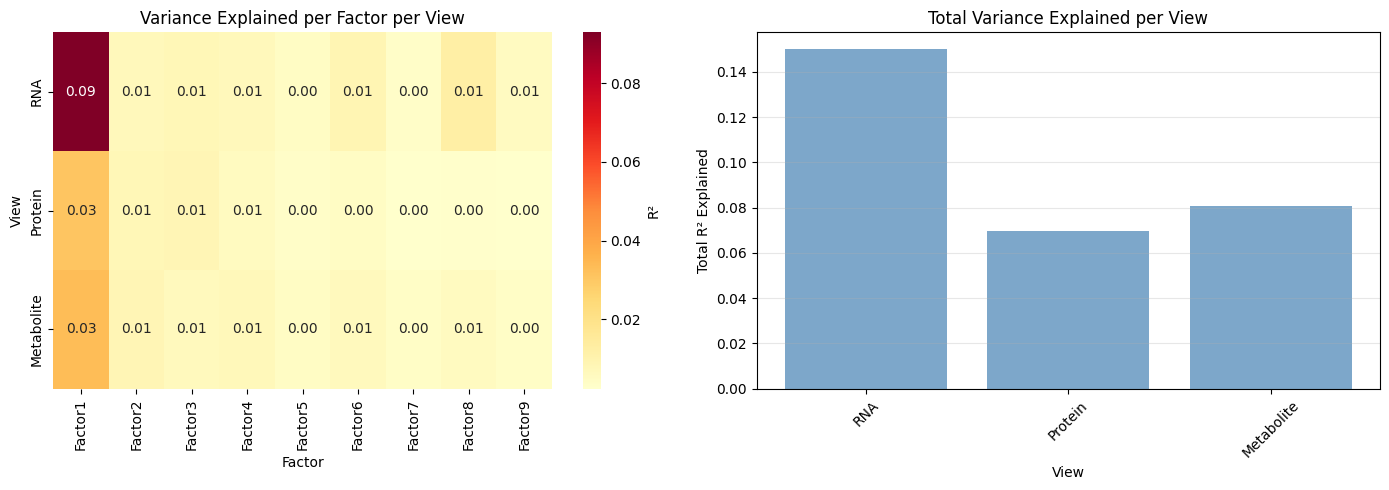

In [45]:
# Plot variance explained
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Variance explained per factor per view
r2_matrix = r2_df.T
sns.heatmap(r2_matrix, annot=True, fmt='.2f', cmap='YlOrRd', ax=axes[0], cbar_kws={'label': 'R²'})
axes[0].set_title('Variance Explained per Factor per View')
axes[0].set_xlabel('Factor')
axes[0].set_ylabel('View')

# Total variance explained per view
total_r2 = r2_df.sum(axis=0)
axes[1].bar(range(len(total_r2)), total_r2, color='steelblue', alpha=0.7)
axes[1].set_xlabel('View')
axes[1].set_ylabel('Total R² Explained')
axes[1].set_title('Total Variance Explained per View')
axes[1].set_xticks(range(len(total_r2)))
axes[1].set_xticklabels(total_r2.index, rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('variance_explained.png', dpi=300, bbox_inches='tight')
print("\nSaved: variance_explained.png")
plt.show()

In [47]:
# ============================================================================
# 7. EXTRACT FACTOR VALUES
# ============================================================================

# Get factor values (latent representation)
factors = ent.model.nodes['Z'].getExpectation()
factor_df = pd.DataFrame(
    factors,
    columns=[f'Factor{i+1}' for i in range(factors.shape[1])],
    index=sample_metadata['sample']
)

# Add metadata
factor_df = factor_df.merge(sample_metadata, left_index=True, right_on='sample')

print("\n=== Factor Values (first few rows) ===")
print(factor_df.head())


=== Factor Values (first few rows) ===
    Factor1   Factor2   Factor3   Factor4   Factor5   Factor6   Factor7  \
0 -0.877428 -0.174724 -0.243133  0.336652  0.023969 -0.010976 -0.031824   
1 -1.231858 -0.173097  0.073352  0.148031  0.062489  0.168240  0.065664   
2 -1.131374 -0.288480  0.088938 -0.304787 -0.051772  0.063537 -0.303821   
3 -1.189427  0.248129  0.278599 -0.587988  0.067224 -0.079651  0.398065   
4 -0.815559  0.021226 -0.317621 -0.166364  0.095821 -0.057575  0.075381   

    Factor8   Factor9    sample condition   batch  
0 -0.327640  0.047164  Sample_1   Control  Batch1  
1 -0.590653  0.384340  Sample_2   Control  Batch2  
2 -0.150774  0.338160  Sample_3   Control  Batch3  
3  0.384014  0.323930  Sample_4   Control  Batch1  
4  0.068837 -0.068001  Sample_5   Control  Batch2  



Saved: factor_values.png


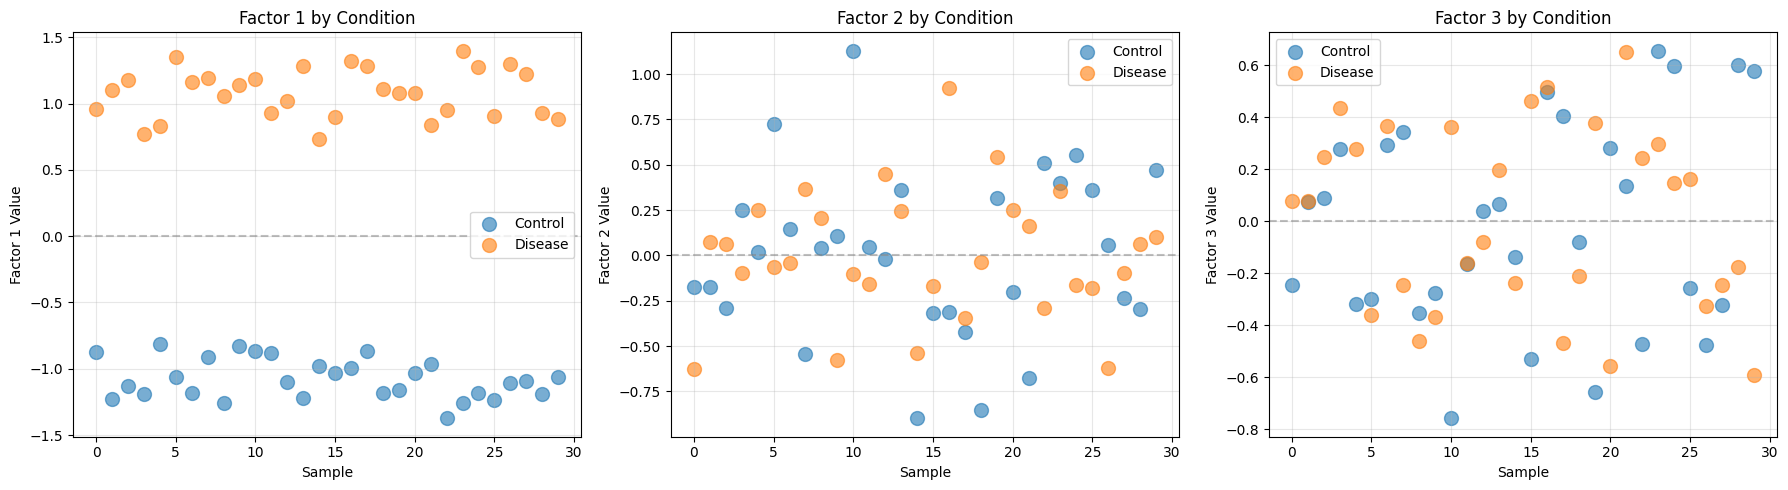

In [48]:
# ============================================================================
# 8. VISUALIZE FACTORS
# ============================================================================

# Plot first 3 factors colored by condition
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, factor_num in enumerate([1, 2, 3]):
    factor_col = f'Factor{factor_num}'
    
    for condition in ['Control', 'Disease']:
        mask = factor_df['condition'] == condition
        axes[idx].scatter(
            range(sum(mask)),
            factor_df.loc[mask, factor_col],
            label=condition,
            alpha=0.6,
            s=100
        )
    
    axes[idx].set_xlabel('Sample')
    axes[idx].set_ylabel(f'Factor {factor_num} Value')
    axes[idx].set_title(f'Factor {factor_num} by Condition')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)
    axes[idx].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('factor_values.png', dpi=300, bbox_inches='tight')
print("\nSaved: factor_values.png")
plt.show()


Saved: factor_scatter.png


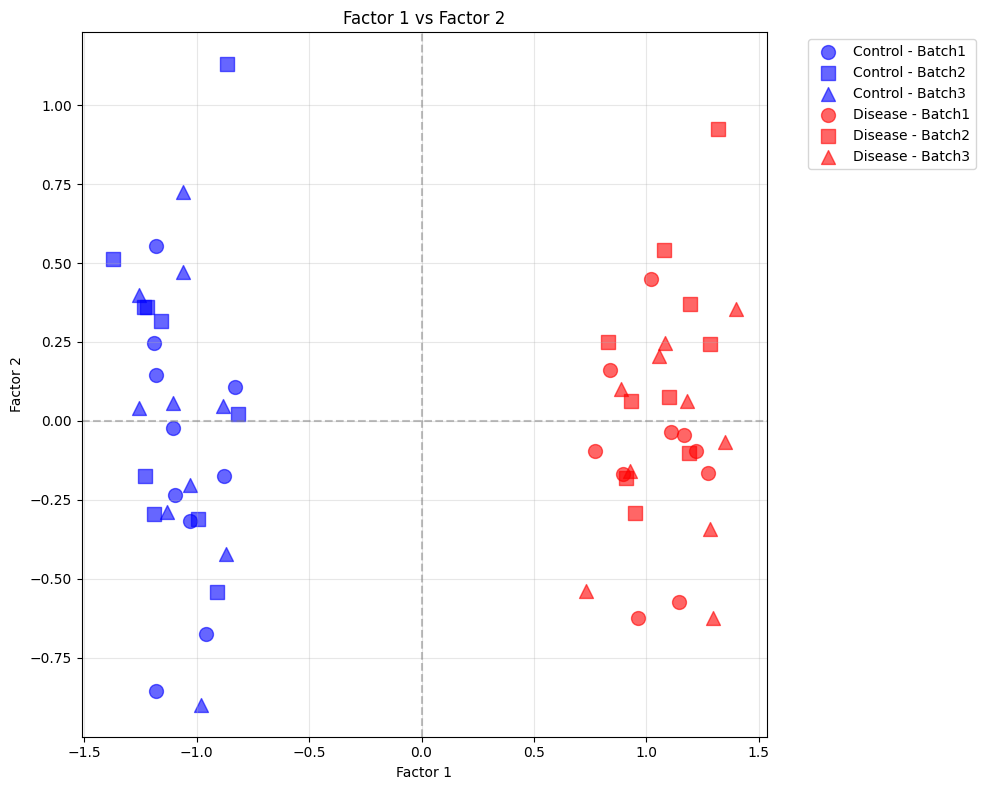

In [49]:
# Create pairwise scatter plot of factors
fig, ax = plt.subplots(figsize=(10, 8))
colors = {'Control': 'blue', 'Disease': 'red'}
markers = {'Batch1': 'o', 'Batch2': 's', 'Batch3': '^'}

for condition in ['Control', 'Disease']:
    for batch in ['Batch1', 'Batch2', 'Batch3']:
        mask = (factor_df['condition'] == condition) & (factor_df['batch'] == batch)
        ax.scatter(
            factor_df.loc[mask, 'Factor1'],
            factor_df.loc[mask, 'Factor2'],
            c=colors[condition],
            marker=markers[batch],
            s=100,
            alpha=0.6,
            label=f'{condition} - {batch}'
        )

ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 2')
ax.set_title('Factor 1 vs Factor 2')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(alpha=0.3)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('factor_scatter.png', dpi=300, bbox_inches='tight')
print("\nSaved: factor_scatter.png")
plt.show()

## 9. EXTRACT AND VISUALISE WEIGHTS

In [ ]:
# Get weights (feature loadings)
weights = ent.model.nodes['W']

print("\n=== Extracting Top Features ===")

# Function to get top features for a view and factor
def get_top_features(weights_dict, view_idx, factor_idx, n_top=20):
    """Extract top features by absolute weight"""
    view_names = ['RNA', 'Protein', 'Metabolite']
    view_name = view_names[view_idx]
    
    # Get weights for this view
    w = weights_dict['E'][view_idx][:, factor_idx]
    
    # Get feature names
    if view_name == 'RNA':
        features = rnaseq_data.index
    elif view_name == 'Protein':
        features = protein_data.index
    else:
        features = metabolite_data.index
    
    # Create dataframe
    weight_df = pd.DataFrame({
        'feature': features,
        'weight': w,
        'abs_weight': np.abs(w)
    }).sort_values('abs_weight', ascending=False).head(n_top)
    
    return weight_df, view_name

# Get top features for Factor 1 from each view
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for view_idx in range(3):
    top_features, view_name = get_top_features(weights, view_idx, 0, n_top=15)
    
    # Plot horizontal bar chart
    axes[view_idx].barh(
        range(len(top_features)),
        top_features['weight'],
        color=['red' if w < 0 else 'blue' for w in top_features['weight']],
        alpha=0.7
    )
    axes[view_idx].set_yticks(range(len(top_features)))
    axes[view_idx].set_yticklabels(top_features['feature'], fontsize=8)
    axes[view_idx].set_xlabel('Weight')
    axes[view_idx].set_title(f'Top Features - Factor 1\n{view_name} View')
    axes[view_idx].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    axes[view_idx].grid(axis='x', alpha=0.3)
    axes[view_idx].invert_yaxis()

plt.tight_layout()
plt.savefig('top_features.png', dpi=300, bbox_inches='tight')
print("\nSaved: top_features.png")
plt.show()

In [ ]:
# ============================================================================
# 10. SAVE RESULTS
# ============================================================================

In [ ]:
# Save factor values
factor_df.to_csv('mofa_factor_values.csv', index=False)
print("\nSaved: mofa_factor_values.csv")

# Save variance explained
r2_df.to_csv('mofa_variance_explained.csv')
print("Saved: mofa_variance_explained.csv")

# Save top features for each factor
all_top_features = []
for factor_idx in range(3):  # First 3 factors
    for view_idx in range(3):  # All views
        top_feat, view_name = get_top_features(weights, view_idx, factor_idx, n_top=50)
        top_feat['factor'] = f'Factor{factor_idx + 1}'
        top_feat['view'] = view_name
        all_top_features.append(top_feat)

top_features_df = pd.concat(all_top_features, ignore_index=True)
top_features_df.to_csv('mofa_top_features.csv', index=False)
print("Saved: mofa_top_features.csv")

In [ ]:
# ============================================================================
# 11. INTERPRETATION SUMMARY
# ============================================================================

In [ ]:
print("\n" + "="*70)
print("=== INTERPRETATION GUIDELINES ===")
print("="*70)
print("\n1. VARIANCE EXPLAINED:")
print("   - Higher R² values indicate factors capturing more variation")
print("   - Look at which views contribute most to each factor")

print("\n2. FACTOR VALUES:")
print("   - Samples with similar factor values have similar molecular profiles")
print("   - Check if factors separate conditions (Control vs Disease)")

print("\n3. FEATURE WEIGHTS:")
print("   - High absolute weights = important features for that factor")
print("   - Positive weights = feature increases with factor value")
print("   - Negative weights = feature decreases with factor value")

print("\n4. SHARED vs UNIQUE PATTERNS:")
print("   - Factors with high variance in MULTIPLE views = shared signal")
print("   - Factors with high variance in ONE view = view-specific pattern")

print("\n5. MISSING DATA:")
print("   - MOFA handles missing data automatically - no imputation needed!")

print("\n" + "="*70)
print("=== ANALYSIS COMPLETE ===")
print("="*70)
print("\nGenerated files:")
print("  - variance_explained.png")
print("  - factor_values.png")
print("  - factor_scatter.png")
print("  - top_features.png")
print("  - mofa_factor_values.csv")
print("  - mofa_variance_explained.csv")
print("  - mofa_top_features.csv")